In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, roc_auc_score
)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [18]:
df = pd.read_csv("/kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
print("Original dataset shape:", df.shape)

# Clean invalid values
df = df.drop_duplicates()
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

# Separate features & labels
X = df.drop(columns=[" Label"])
y = df[" Label"]

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

print("Processed dataset shape:", X.shape, y.shape)

Original dataset shape: (225745, 79)
Processed dataset shape: (223112, 78) (223112,)


In [19]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

def make_loader(X, y, batch_size=128):
    tensor_x = torch.tensor(X, dtype=torch.float32)
    tensor_y = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(tensor_x, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = make_loader(X_train, y_train)
val_loader   = make_loader(X_val, y_val)
test_loader  = make_loader(X_test, y_test, batch_size=256)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y))


In [20]:
class TinyCNN(nn.Module):
    def __init__(self, input_dim, emb_dim=32):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )
        self.fc = nn.Linear(32, emb_dim)
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.squeeze(-1)
        emb = self.fc(x)
        return self.classifier(emb)

class ShallowNN(nn.Module):
    def __init__(self, input_dim, emb_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, emb_dim)
        )
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        emb = self.net(x)
        return self.classifier(emb)

class HybridCNNShallow(nn.Module):
    def __init__(self, input_dim, emb_dim=32):
        super().__init__()
        self.cnn = TinyCNN(input_dim, emb_dim)
        self.shallow = ShallowNN(input_dim, emb_dim)
        self.classifier = nn.Sequential(
            nn.Linear(2*emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        cnn_emb = self.cnn.fc(self.cnn.conv(x.unsqueeze(1)).squeeze(-1))
        shallow_emb = self.shallow.net(x)
        combined = torch.cat([cnn_emb, shallow_emb], dim=1)
        return self.classifier(combined)


In [21]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        pt = torch.exp(-ce_loss)
        focal = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal.mean() if self.reduction == 'mean' else focal.sum()

In [22]:
def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = FocalLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - train_loss: {total_loss/len(train_loader):.4f}")

    return model


In [23]:
def evaluate(model, loader, name="Model"):
    device = next(model.parameters()).device
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            probs = torch.softmax(preds, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(torch.argmax(preds, dim=1).cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    acc = accuracy_score(all_labels, all_preds)
    pre = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    rec = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"\n{name} Evaluation Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {pre:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve (one-vs-rest if multiclass)
    if num_classes == 2:
        fpr, tpr, _ = roc_curve(all_labels, all_probs[:,1])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
        plt.plot([0,1], [0,1], "k--")
        plt.title(f"{name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()
    else:
        roc_auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")
        print(f"Multiclass ROC AUC: {roc_auc:.4f}")

    return acc, pre, rec, f1


Training TinyCNN...
Epoch 1/5 - train_loss: 0.0253
Epoch 2/5 - train_loss: 0.0077
Epoch 3/5 - train_loss: 0.0059
Epoch 4/5 - train_loss: 0.0045
Epoch 5/5 - train_loss: 0.0036

TinyCNN Evaluation Metrics:
Accuracy:  0.9990
Precision: 0.9990
Recall:    0.9990
F1-score:  0.9990


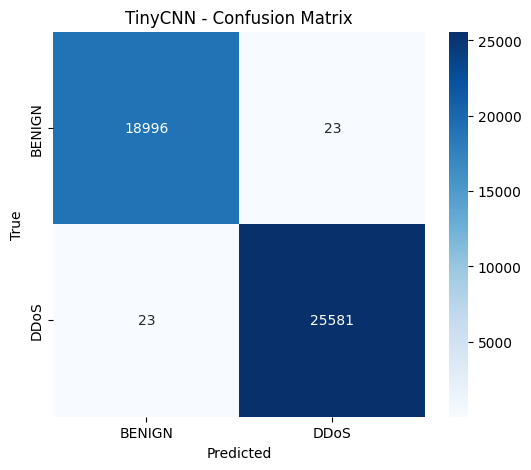

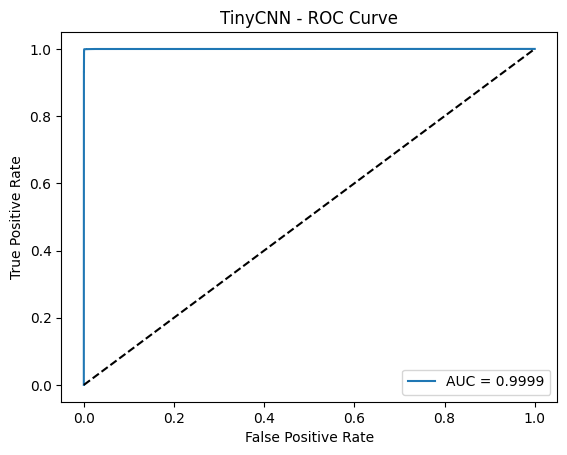


Training ShallowNN...
Epoch 1/5 - train_loss: 0.0065
Epoch 2/5 - train_loss: 0.0019
Epoch 3/5 - train_loss: 0.0013
Epoch 4/5 - train_loss: 0.0012
Epoch 5/5 - train_loss: 0.0011

ShallowNN Evaluation Metrics:
Accuracy:  0.9990
Precision: 0.9990
Recall:    0.9990
F1-score:  0.9990


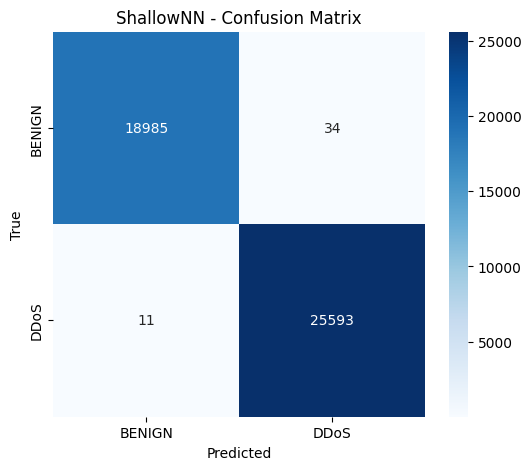

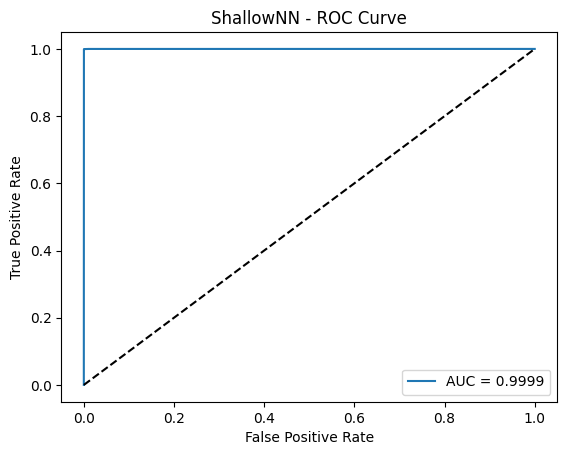


Training HybridCNNShallow...
Epoch 1/5 - train_loss: 0.0058
Epoch 2/5 - train_loss: 0.0011
Epoch 3/5 - train_loss: 0.0010
Epoch 4/5 - train_loss: 0.0009
Epoch 5/5 - train_loss: 0.0008

HybridCNNShallow Evaluation Metrics:
Accuracy:  0.9984
Precision: 0.9984
Recall:    0.9984
F1-score:  0.9984


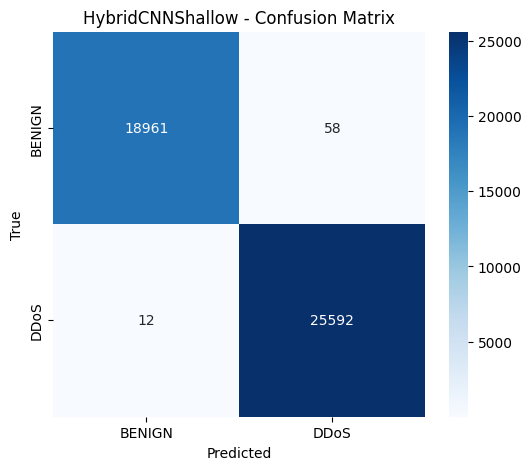

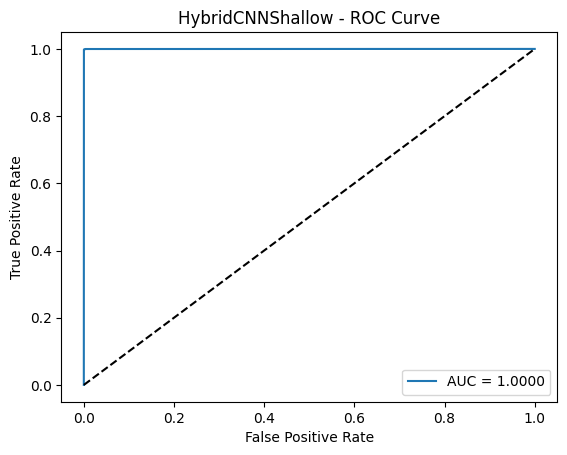


Ablation Summary:
               Model  Accuracy  Precision    Recall        F1
0           TinyCNN  0.998969   0.998969  0.998969  0.998969
1         ShallowNN  0.998992   0.998992  0.998992  0.998991
2  HybridCNNShallow  0.998431   0.998433  0.998431  0.998431


In [24]:
results = []

for name, ModelClass in [
    ("TinyCNN", TinyCNN),
    ("ShallowNN", ShallowNN),
    ("HybridCNNShallow", HybridCNNShallow)
]:
    print(f"\nTraining {name}...")
    model = ModelClass(input_dim=input_dim, emb_dim=32)
    model = train_model(model, train_loader, val_loader, epochs=5)
    acc, pre, rec, f1 = evaluate(model, test_loader, name)
    results.append({"Model": name, "Accuracy": acc, "Precision": pre, "Recall": rec, "F1": f1})

df_results = pd.DataFrame(results)
print("\nAblation Summary:\n", df_results)
df_results.to_csv("ablation_summary.csv", index=False)
